<a href="https://colab.research.google.com/github/MeidanGR/SpeechEmotionRecognition_Realtime/blob/main/SpeechEmotionRecognition_DL_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Speech Emotion Recognition (SER) in real-time**
### **A Deep Learning (LSTM) model with keras.**

### Final project (B.Sc. requirement)  
Development by **Meidan Greenberg & Linoy Hadad.**

Instructor: **Dr. Dima Alberg**

Industial Engineering and Management dept.

SCE Collage, Israel.




# **ABSTRACT**
This study aims to investigate and implement an Artificial Intelligence (AI) algorithm that will analyze an audio file in real-time, identify and present the expressed emotion within it. 

This classification model is developed in a Deep Learning method, meaning a Deep Neural Network (DNN) while an advanced model for time-series analysis has been chosen, which is the Long Short-Term Memory (LSTM). 

For the train of the model, expressed emotions by actors have been used from The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) from the Ryerson University, as well as the Toronto Emotional Speech Set (TESS) from the University of Toronto.

Results had shown an accuracy of 85% of emotional recognition from speech.

This notebook contains the first part of the study, ahead of a real-time algorithm for speech emotion recognition system (SER).


---



# **LIBRARIES & GOOGLE AUTH**

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [2]:
%%capture
!pip install pydub
!pip install noisereduce
#!pip install tensorflow

In [3]:
%%capture
import numpy as np
import pandas as pd

import os
from pydub import AudioSegment, effects
import librosa
import noisereduce as nr

import tensorflow as tf
import keras
import sklearn

# **THE DATA**
The speech emotion audio databases used:

- **The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)**
https://zenodo.org/record/1188976#.X4sE0tDXKUl
  - The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) was recorded with 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression. 
  - **1440 files** = 24 actors x 60 trails per actor
  - **8 Emotions** (neutral, calm, happy, sad, angry, fearful, disgust, surprised).

- **Toronto Emotional Speech Set (TESS)**
https://tspace.library.utoronto.ca/handle/1807/24487
  - These stimuli were modeled on the Northwestern University Auditory Test No. 6 (NU-6; Tillman & Carhart, 1966). A set of 200 target words were spoken in the carrier phrase "Say the word _____' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions described below.
Two actresses were recruited from the Toronto area. Both actresses speak English as their first language, are university educated, and have musical training. Audiometric testing indicated that both actresses have thresholds within the normal range.
  - **2800 files** = 2 actors x 200 pharses x 7 emotions
  - **7 Emotions** (neutral, happiness, sadness, anger, fear, disgust, pleasant surprise)
   - ('calm' is not a part of this DB)


# **DATA PREPROCESSING**

The preprocessing is described in the following diagram.
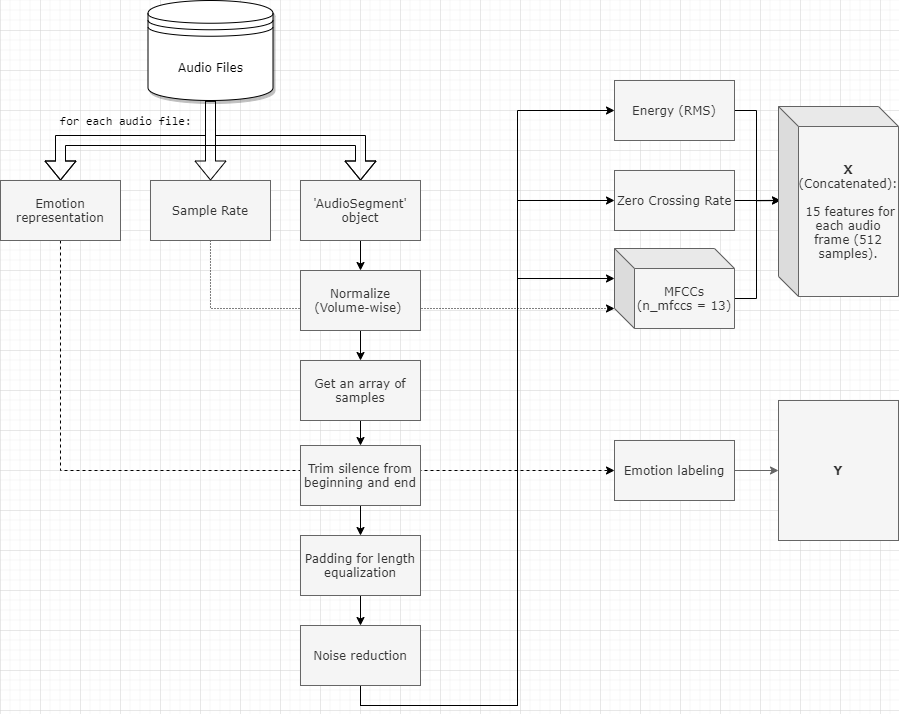

## **Audio loading & data extraction**
The following data is extracted from each audio file:
1.   **Emotion representation**

    *   RAVDESS: The filename contains a number that represents an emotion, e.g. 03 is happy.
    *   TESS: The filename contains a direct representation of an emotion, e.g 'happy'.


2.   **Sample Rate**: number of audio samples per second. RAVDESS database was recorded in 48kHz, and the TESS database was recorded in 22.5kHz. 

3. **The audio** is processed in the following order:


*   'AudioSegment' instance: The audio is loaded to an object by the library 'AudioSegment'.
*   Normalization: Each 'AudioSegment' object is normalized to + 5.0 dBFS. 

*   Transforming the object to an array of samples is crucial for the rest of the preprocessing.
*   Trimming the silence in the beginning and the end, to get rid of unnecessary data.
*   Padding every audio file to the same length, for length equalization.
*   Noise reduction is being performed.


---
First, the preprocessing will be executed for a single audio file, accompanied by visualizations.















## **Demonstration on a single audio file**

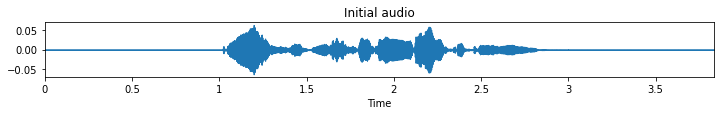

In [6]:
# Presenting the preprocessing for a single audio file.

import matplotlib.pyplot as plt
from librosa import display   
import IPython.display as ipd 

path = '/content/drive/My Drive/AudioFiles/RAVDESS/Actor_02/03-01-02-01-02-01-02.wav'

# 1. Loading the audio file into an 'AudioSegment' object, and extracting the sample rate. 
#    'x' is an array of samples that is only relevant for visualization at this part.

rawsound = AudioSegment.from_file(path)
x, sr = librosa.load(path, sr = None)

plt.figure(figsize=(12,1))
librosa.display.waveplot(x, sr)
plt.title('Initial audio')

rawsound

The actual audio as well as the 'y' axis range suggests that the initial audio is very low-volumed. This can interfere with the feature extraction validity.




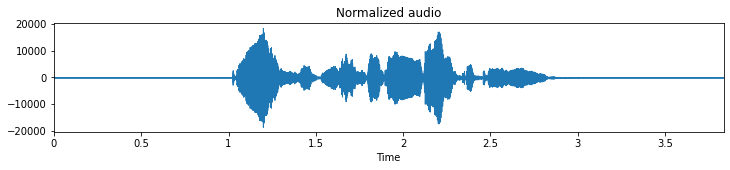

In [ ]:
# 2. Normalizing to +5.0 dBFS.

normalizedsound = effects.normalize(rawsound, headroom = 5.0) 

plt.figure(figsize=(12,2))
librosa.display.waveplot(normal_x, sr)
plt.title('Normalized audio')

normalizedsound

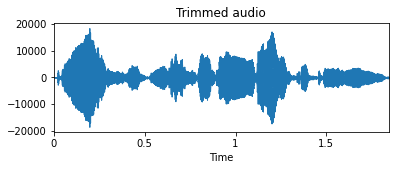

In [ ]:
# 3. Transforming audio to an array, Trimming silence in the beginning and end.

normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
xt, index = librosa.effects.trim(normal_x, top_db = 30)

plt.figure(figsize=(6,2))
librosa.display.waveplot(xt, sr)
plt.title('Trimmed audio')

ipd.display(ipd.Audio(data = xt, rate=sr))

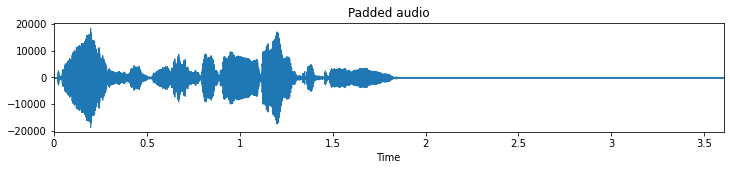

In [ ]:
# 4. Right-side padding for length equalization.
#    173056 = maximum lengthed audio (the extraction of this value is performed later in this notebook.)

padded_x = np.pad(xt, (0, 173056-len(xt)), 'constant')

plt.figure(figsize=(12,2))
librosa.display.waveplot(padded_x, sr)
plt.title('Padded audio')

ipd.display(ipd.Audio(data = padded_x, rate=sr))

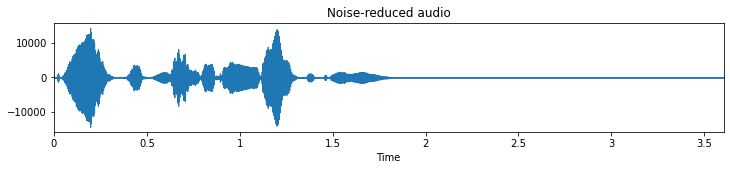

In [ ]:
# 5. Noise reduction
#    Note: although there is no noise to reduce from RAVDESS nor TESS databases, reduce_noise function by noisereduce library attributes a uniform stamper to the audio files. 

final_x = nr.reduce_noise(audio_clip=padded_x, 
                          noise_clip=padded_x, 
                          verbose=False)

plt.figure(figsize=(12,2))
librosa.display.waveplot(final_x, sr)
plt.title('Noise-reduced audio')

ipd.display(ipd.Audio(data = final_x, rate=sr))

## **Features extraction**
The selected features being extracted for the speech emotional recognition are:

1.   Energy - Root Mean Square (RMS)
2.   Zero Crossed Rate (ZCR)
3.   Mel-Frequency Cepstral Coefficients (MFCCs) 

Every 2048 samples (~0.058 seconds on average) are being analyzed, and being translated to 4 sequential values (2048 / 512 = 4). In total, for an audio file lengthed 173056 samples, considering the last sample, 339 sequential values are returned for each feature  (173056+1 / 512 = 339).

In [ ]:
# Feature extraction

frame_length = 2048
hop_length = 512

f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square (RMS)
print(f1.shape)
f2 = librosa.feature.zero_crossing_rate(final_x, frame_length=frame_length, hop_length=hop_length) # Zero Crossed Rate (ZCR)
print(f2.shape)
f3 = librosa.feature.mfcc(final_x, sr=sr, S=None, n_mfcc=13, hop_length = hop_length) # MFCCs
print(f3.shape)


(1, 339)
(1, 339)
(13, 339)


## **Emotion representation**
There is a different representation of the emotions in each database.

#### **RAVDESS Database**

*   A RAVDESS filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4). The format which carries only emotion expressed by speech is taken as 03-01-X-X-X-X-X.wav, as the 8 emotions are stated in the 3rd part (The 1st 'X' within the format).

 
#### **TESS Database**

*   A TESS file name contains the emotion by a direct text, e.g. "YAF_youth_happy.wav". 

*    To overcome this incompatibility with the RAVDESS representation, "find_emotion" function has been executed.



In addition, classification modeling accepting only values starting from zero, thus "emotionfix" function has been executed for all files, performing an 'n = n-1' process for the emotion representation.

In [ ]:
# Emotion kind validation function for TESS database, due to emotions written within the file names.
def find_emotion(name): 
        if('neutral' in name): return "01"
        elif('happy' in name): return "03"
        elif('sad' in name): return "04"
        elif('angry' in name): return "05"
        elif('fear' in name): return "06"
        elif('disgust' in name): return "07"
        elif('ps' in name): return "08"
        else: return "-1"
        
# 'emotions' list fix for classification purposes:
#     Classification values start from 0, Thus an 'n = n-1' operation has been executed:
def emotionfix(e_num):
    if e_num == "01":   return 0 # neutral
    elif e_num == "02": return 1 # calm
    elif e_num == "03": return 2 # happy
    elif e_num == "04": return 3 # sad
    elif e_num == "05": return 4 # angry
    elif e_num == "06": return 5 # fear
    elif e_num == "07": return 6 # disgust
    else:               return 7 # suprised

In [ ]:
# Maximum samples (frames) count for padding purposes.

frames = []
folder_path = '/content/drive/My Drive/AudioFiles'

for subdir, dirs, files in os.walk(folder_path):
  for file in files: 
    x, sr = librosa.load(path = os.path.join(subdir,file), sr = None)
    xt, index = librosa.effects.trim(x, top_db=30)
     
    frames.append(len(xt))

print('Maximum sample length:', np.max(frames))                   

Maximum sample length: 173056


## **The Full Preprocess**
Following the preprocessing presentation for a single audio file, the full data (File names, audio, sample rates, the features and the emotions) will be extracted.

In [ ]:
# Initializing data lists
filenames = []
audio_data = []
sample_rate = []
rms = []
zcr = []
mfcc = []
emotions = []

# Initializing variables
frame_length = 2048
hop_length = 512
total_length = 173056 # desired frame length for all of the audio samples.

folder_path = '/content/drive/My Drive/AudioFiles'

for subdir, dirs, files in os.walk(folder_path):
  for file in files: 

    # Fetching sample rate.
      _, sr = librosa.load(path = os.path.join(subdir,file), sr = None) # sr (the sample rate) is used for librosa's MFCCs. '_' is irrelevant.
    # Loading audio file.
      rawsound = AudioSegment.from_file(os.path.join(subdir,file)) 
    # The audio is being normalized to 5.0 dBFS.
      normalizedsound = effects.normalize(rawsound, headroom = 5.0) 
    # Transforming the normalized audio to np.array of samples.
      normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
    # Trimming silence from the beginning and the end.
      xt, index = librosa.effects.trim(normal_x, top_db=30)
    # Padding for duration equalization.
      padded_x = np.pad(xt, (0, total_length-len(xt)), 'constant') # Padding to maximum frame number in the database to get length equalization.
    # Noise reduction
      final_x = nr.reduce_noise(audio_clip = padded_x, noise_clip = padded_x, verbose=False)
       
   # Features & emotion extraction from the different databases
      f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square   
      f2 = librosa.feature.zero_crossing_rate(final_x , frame_length=frame_length, hop_length=hop_length,center=True) # ZCR      
      f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC

      if (find_emotion(file) != "-1"): #TESS database validation
            name = find_emotion(file)
      else:                            #RAVDESS database validation
            name = file[6:8]           

   # Filling the data lists  
      filenames.append(file)     
      audio_data.append(final_x) 
      sample_rate.append(sr)
      rms.append(f1)
      zcr.append(f2)
      mfcc.append(f3)
      emotions.append(emotionfix(name)) 

### **Dataframe representation** 
The full data can be reviewed using a pandas dataframe.  

In [ ]:
df = pd.DataFrame(columns= ['name', 'frames','audio','sample_rate', 'mfccs', 'zcr', 'rms', 'y']) 

df.name = filenames
df.frames = frames
df.audio = audio_data
df.sample_rate = sample_rate
df.mfccs = mfcc
df.zcr = zcr
df.rms = rms
df.y = emotions

print(df.info())
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4232 entries, 0 to 4231
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         4232 non-null   object
 1   frames       4232 non-null   int64 
 2   audio        4232 non-null   object
 3   sample_rate  4232 non-null   int64 
 4   mfccs        4232 non-null   object
 5   zcr          4232 non-null   object
 6   rms          4232 non-null   object
 7   y            4232 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 264.6+ KB
None


,name,frames,audio,sample_rate,mfccs,zcr,rms,y
2474,OAF_sell_neutral.wav,54732,"[-10.673780673850647, -40.68788462425525, -36....",24414,"[[478.33003960094936, 480.96570930392227, 490....","[[0.0, 0.01123046875, 0.0302734375, 0.08544921...","[[408.69077295451854, 323.23917880163475, 364....",0
3166,YAF_germ_neutral.wav,51567,"[191.0406951508889, 8.628223164126693, 40.8281...",24414,"[[633.6417466052134, 657.6653364258901, 657.14...","[[0.263671875, 0.427734375, 0.59765625, 0.6533...","[[636.6451040276024, 923.3419069380435, 1351.7...",0
1121,03-01-07-01-01-01-19.wav,153600,"[-11.617478507061646, -16.26219511155538, -23....",48000,"[[449.8716165497258, 426.794852076198, 382.863...","[[0.00927734375, 0.013671875, 0.01708984375, 0...","[[69.34010728392879, 65.20768413472818, 51.837...",6
3921,YAF_shout_neutral.wav,46701,"[50.40799971479768, 5.985294187801723, -46.576...",24414,"[[568.9585069235713, 600.2443929969702, 600.18...","[[0.23486328125, 0.40576171875, 0.5849609375, ...","[[285.90525597975346, 526.8200830096883, 822.7...",0
3775,YAF_read_ps.wav,40960,"[-13.02830037259053, -46.734770482262924, -72....",24414,"[[562.0495994433549, 591.9884606859589, 585.16...","[[0.2421875, 0.41650390625, 0.60107421875, 0.7...","[[399.009363108936, 570.8650399106801, 835.321...",7


**Note: a total of 8 files had been removed from both databases due to various file corruptions.**

# **AUDIO & EMOTION CHECKS**
**Emotions legend:**



*   0: neutral
*   1: calm
*   2: happy
*   3: sad
*   4: angry
*   5: fear
*   6: disgust
*   7: suprised


In [ ]:
#Enter a row num between [0-4231]
row = 521
print('File Name:', df.name[row])
print('Emotion:', df.y[row])

ipd.display(ipd.Audio(data = df.audio[row], rate=df.sample_rate[row]))

File Name: 03-01-07-01-01-01-09.wav
Emotion: 6


# **FINAL DATA SETUP**
In order to input the data into a model, a few adjustments should be made:


*   The shapes of the features must be uniform, and in the 3D format: 

 **(batch, timesteps, feature)**
*   Concatenating all features to a single 'X' variable.
*   Adjustment of 'Y' with a 2D shape.
*   Split of X, Y to the training set and validation test.
*   y_train and y_test conversion to 'One-hot' vectors for classification purposes.




In [ ]:
# Adjusting features shape to the 3D format: (batch, timesteps, feature)

f_rms = np.asarray(rms).astype('float32')
f_rms = np.swapaxes(f_rms,1,2)
f_zcr = np.asarray(zcr).astype('float32')
f_zcr = np.swapaxes(f_zcr,1,2)
f_mfccs = np.asarray(mfcc).astype('float32')
f_mfccs = np.swapaxes(f_mfccs,1,2)

print('ZCR shape:',f_zcr.shape)
print('RMS shape:',f_rms.shape)
print('MFCCs shape:',f_mfccs.shape)

ZCR shape: (4232, 339, 1)
RMS shape: (4232, 339, 1)
MFCCs shape: (4232, 339, 13)


In [ ]:
# Concatenating all features to 'X' variable.
X = np.concatenate((f_zcr,f_rms, f_mfccs), axis=2)

# Preparing 'Y' as a 2D shaped variable.
Y = np.asarray(emotions).astype('int8')
Y = np.expand_dims(Y, axis=1)

# Split to training and validation (test) sets.
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.125, random_state = 37)

#'One-hot' vectors for Y: emotion classification
y_train_class = tf.keras.utils.to_categorical(y_train, 8, dtype = 'int8')
y_test_class = tf.keras.utils.to_categorical(y_test, 8, dtype = 'int8')

# **MODEL DEFINITION & TRAIN**
The model is executed with keras library, using 2 hidden layers with 64 nodes, and an output (dense) layer with 8 nodes, each for one emotion using the 'softmax' activation.
The optimizer that led to the best results was 'RMSProp' with default parameters.

The batch size chosen is 23, which is a factor of both training set samples (3703) and validation set samples (529).

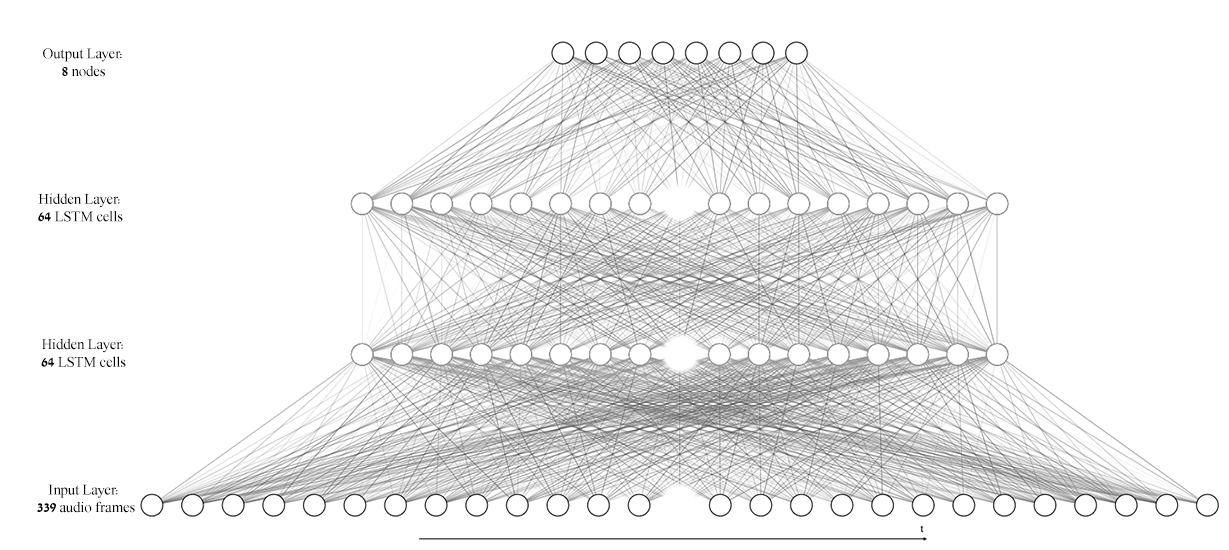

In [ ]:
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import callbacks 

In [ ]:
# Initializing the model

model = Sequential()
model.add(layers.LSTM(64,return_sequences = True, input_shape=(X.shape[1:3])))
model.add(layers.LSTM(64))
model.add(layers.Dense(8, activation = 'softmax'))
print(model.summary())

batch_size = 23

# Callbacks functions
mcp_save = callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True,
                           monitor='val_categorical_accuracy',
                           mode='max')

rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                    factor=0.1, patience=100)
                             
# Compile & train   
model.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])

history = model.fit(x_train, y_train_class, 
                      epochs=150, batch_size = batch_size, 
                      validation_data = (x_test, y_test_class), 
                      callbacks = [mcp_save, rlrop])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 339, 64)           20480     
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 520       
Total params: 54,024
Trainable params: 54,024
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
161/161 [==============================] - 64s 361ms/step - loss: 2.0675 - categorical_accuracy: 0.1253 - val_loss: 2.0338 - val_categorical_accuracy: 0.1512
Epoch 2/150
161/161 [==============================] - 57s 356ms/step - loss: 2.0440 - categorical_accuracy: 0.1522 - val_loss: 2.0190 - val_categorical_accuracy: 0.1777
Epoch 3/150
161/161 [==============

# **MODEL EVALUATION**
The model has been evaluated with the following factors:


1.   A visualization of the loss and categorial accuracy values trend during the training process.
2.   A confusion matrix for visualizing the number of successful predictions of each emotion.
3.   Model's prediction accuracy rates for each emotion.


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Test Loss: 0.5294
Test Acc: 0.8507


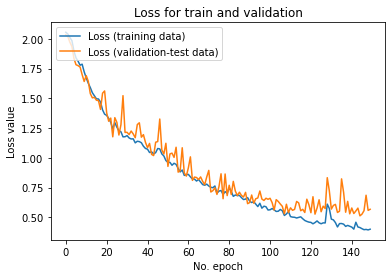

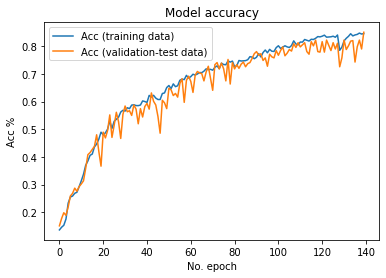

In [ ]:
# Loss, Accuracy presentation

n = 140 # the best epoch which gained 85.07% accuracy

print(f"Test Loss: {(history.history['val_loss'][n-1]):0.4f}") 
print(f"Test Acc: {np.max(history.history['val_categorical_accuracy']):0.4f}")

# Plot history: Loss
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation-test data)')
plt.title('Loss for train and validation')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

#Plot history: Accuracy
plt.plot(history.history['categorical_accuracy'][0:n], label='Acc (training data)')
plt.plot(history.history['val_categorical_accuracy'][0:n], label='Acc (validation-test data)')
plt.title('Model accuracy')
plt.ylabel('Acc %')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

Text(0.5, 51.0, 'Predicted emotion')

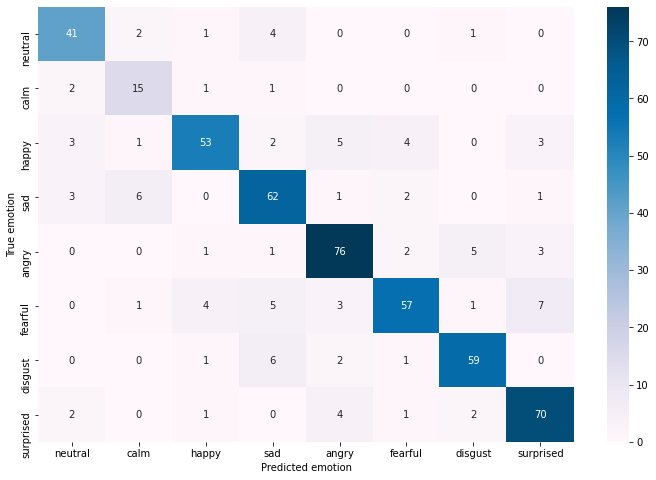

In [ ]:
# Confusion matrix

y_test_class = np.argmax(y_test_class, axis=1)
predictions = model.predict(x_test)
y_pred_class = np.argmax(predictions, axis=1)

cm=confusion_matrix(y_test_class, y_pred_class)

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
 
cm_df = pd.DataFrame(cm,index,columns)                      
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'PuBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

In [ ]:
# Prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Predicted emotions accuracy:
neutral : 0.8367
calm : 0.7895
happy : 0.7465
sad : 0.8267
angry : 0.8636
fearful : 0.7308
disgust : 0.8551
surprised : 0.8750


# **RESULTS & CONCLUSIONS**
As seen, the accuracy of the model had come up to 85.07%, with slightly over-fitting around the 120th epoch but the model can be considered as having a good fit. The accuracy had been influenced by the data preprocessing, specific feature selection, and model definition.
Within the next part of the study in which the model will be used as a Real-time SER, The inputs will be processed similarly as the training and test set, to gain similarity and therefore, precision. 

In [ ]:
# Saving model & weights

from keras.models import model_from_json
from keras.models import load_model

model_json = model.to_json()

with open("model_8507.json", "w") as json_file:
    json_file.write(model_json)
    
model.save_weights("model_8507.h5")